# Creating Metric for (Over)Underserved Communities for the SBA

This notebook will create the metric for over/underserved communities in the areas servied by the SF District SBA office. We define the metric as number of approved loans divided by total number of businesses in the area. To start, we will use "incorporated places" as the unit of geography that we're interested in.

In [39]:
%matplotlib inline

import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pylab as plt
import csv
import folium
from pylab import *

In [40]:
pd.set_option('display.max_columns', None)

In [41]:
df = pd.read_csv('./data/SFDO_504_7A-clean.csv')
city_profile = pd.read_excel('./data/0912 - City Profiles.xlsx')

## Exploring the Data

In [8]:
df.shape

(44186, 39)

In [25]:
print("Different types of Businesses")
print(df.BusinessType.unique())
print("Different Loan Statuses")
print(df.LoanStatus.unique())
print("Different Cities")
print(df.BorrCity.unique())

Different types of Businesses
['INDIVIDUAL' 'CORPORATION' 'PARTNERSHIP' nan]
Different Loan Statuses
['CHGOFF' 'PIF' 'CANCLD' 'EXEMPT' 'COMMIT' nan 'NOT FUNDED']
Different Cities
['YOUNTVILLE' 'YORKVILLE' nan 'WOODSIDE' 'WOODLAND HILLS' 'WOODLAND'
 'WOODACRE' 'WINDSOR' 'WILTON' 'WILLOW CREEK' 'WILLITS' 'WHITETHORN'
 'WESTPORT' 'WESTLEY' 'WEST SACRAMENTO' 'WEST PITTSBURG' 'WEST HOLLYWOOD'
 'WEST GUERNEWOOD' 'WATSONVILLE' 'WARM SPRINGS' 'WALNUT CREEK'
 'VINTAGE WAY' 'VAN NUYS' 'VALLEY FORD' 'VALLEJO' 'VACAVILLE' 'UPPER LAKE'
 'UNION CITY' 'UKIAH' 'TURLOCK' 'TRUCKEE' 'TRINIDAD' 'TRACY' 'TORRENCE'
 'TOMALES' 'TIBURON' 'SUNOL' 'SUNNYVALE' 'SUISUN CITY' 'STONERIDGE MALL'
 'STOCKTON' 'STINSON BEACH' 'STANFORD' 'SPRING VALLEY'
 'SOUTH SAN FRANCISCO' 'SOUTH LAKE TAHOE' 'SOQUEL' 'SONOMA' 'SOLONO'
 'SMITH RIVER' 'SHELTER COVE' 'SHASTA LAKE' 'SEBASTOPOL' 'SEBASTIANI'
 'SEA RANCH' 'SCOTTS VALLEY' 'SCOTIA' 'SAUSALITO' 'SARATOGA' 'SANTA ROSA'
 'SANTA MONICA' 'SANTA MARIA' 'SANTA CRUZ' 'SANTA CLARA' '

In [22]:
city_profile.head(1)

,Name,Sq Mi,Zip Codes,GeoID,County,Pop,Pop Density,# of businesses (referenceUSA),# of businesses (mergent),# of businesses (census community survey),# of businesses Average,# of businesses per sq. mile (referenceUSA),# of businesses per sq. mile (mergent),# of businesses per sq. mile (Census),# of businesses per sq. mile (average),City-Lat,City-Lon
0,Blue Lake,0.59,95525,607162,Humboldt,1253,2123.728814,67.0,185,25.0,92.333333,113.559322,313.559322,42.372881,156.497175,40.88291,-123.98395


In [26]:
df.head(5)

,Column,Program,BorrName,BorrStreet,BorrCity,BorrState,BorrZip,BankName,BankStreet,BankCity,BankState,BankZip,GrossApproval,SBAGuaranteedApproval,ApprovalDate,ApprovalFiscalYear,FirstDisbursementDate,DeliveryMethod,subpgmdesc,InitialInterestRate,TermInMonths,NaicsCode,NaicsDescription,FranchiseCode,FranchiseName,ProjectCounty,ProjectState,SBADistrictOffice,CongressionalDistrict,BusinessType,LoanStatus,ChargeOffDate,GrossChargeOffAmount,RevolverStatus,JobsSupported,ThirdPartyLender_Name,ThirdPartyLender_City,ThirdPartyLender_State,ThirdPartyDollars
0,3098.0,7A,PER CASO PRODUCTIONS,6600 YOUNT ST #12,YOUNTVILLE,CA,94599.0,Bank of Hope,"3731 Wilshire Blvd, Ste 1000",LOS ANGELES,CA,90010.0,15000.0,12750.0,9/19/2006,2006.0,9/30/2006,COMM EXPRS,Community Express,NaN,53.0,323119.0,Other Commercial Printing,0.0,NaN,NAPA,CA,SAN FRANCISCO DISTRICT OFFICE<U+00A0>,5.0,INDIVIDUAL,CHGOFF,6/17/2009,11775.0,0.0,2.0,NaN,NaN,NaN,NaN
1,4752.0,504,WINE GARDEN LLC,6476 WASHINGTON STREET,YOUNTVILLE,CA,94599.0,Bay Area Employment Development Company,1801 Oakland Boulevard,Walnut Creek,CA,94596.0,881000.0,NaN,9/22/2003,2003.0,11/17/2004,NaN,Sec. 504 - Loan Guarantees - Private Sector Fi...,NaN,240.0,722410.0,Drinking Places (Alcoholic Beverages),1.0,NaN,NAPA,CA,SAN FRANCISCO DISTRICT OFFICE<U+00A0>,5.0,CORPORATION,PIF,NaN,0.0,NaN,25.0,NaN,NaN,NaN,NaN
2,5338.0,7A,BORDEAUX HOUSE,6600 WASHINGTON STREET,YOUNTVILLE,CA,94599.0,Bank of the West,180 Montgomery St,SAN FRANCISCO,CA,94104.0,527200.0,369040.0,5/5/1994,1994.0,7/31/1994,PLP,Guaranty,NaN,284.0,NaN,NaN,1.0,NaN,NAPA,CA,SAN FRANCISCO DISTRICT OFFICE<U+00A0>,5.0,INDIVIDUAL,PIF,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN
3,5836.0,7A,"VITA PARTNERS, LLC",6725 WASHINGTON STREET,YOUNTVILLE,CA,94599.0,First Republic Bank,111 Pine St,SAN FRANCISCO,CA,94111.0,800000.0,720000.0,7/14/2009,2009.0,NaN,PLP,Guaranty,5.5,120.0,722110.0,Full-Service Restaurants,0.0,NaN,NAPA,CA,SAN FRANCISCO DISTRICT OFFICE<U+00A0>,5.0,CORPORATION,CANCLD,NaN,0.0,0.0,85.0,NaN,NaN,NaN,NaN
4,12154.0,7A,NAPA VALLEY BIKE TOURS AND NAP,6488 WASHINGTON ST,YOUNTVILLE,CA,94599.0,"Wells Fargo Bank, National Association",101 N Philips Ave,SIOUX FALLS,SD,57104.0,210000.0,157500.0,6/5/2007,2007.0,6/30/2007,PLP,Guaranty,NaN,120.0,561520.0,Tour Operators,1.0,NaN,NAPA,CA,SAN FRANCISCO DISTRICT OFFICE<U+00A0>,5.0,CORPORATION,PIF,NaN,0.0,0.0,8.0,NaN,NaN,NaN,NaN


In [11]:
df['JobsSupported'].groupby(df['LoanStatus']).describe()

LoanStatus       
CANCLD      count     4512.000000
            mean        10.077128
            std         70.396957
            min          0.000000
            25%          0.000000
            50%          3.000000
            75%          9.000000
            max       4492.000000
CHGOFF      count     4851.000000
            mean         7.348382
            std         66.397095
            min          0.000000
            25%          1.000000
            50%          3.000000
            75%          7.000000
            max       4492.000000
COMMIT      count      666.000000
            mean         6.046547
            std         14.478377
            min          0.000000
            25%          0.000000
            50%          2.000000
            75%          6.000000
            max        250.000000
EXEMPT      count     9726.000000
            mean        10.680547
            std         20.528830
            min          0.000000
            25%          2.000

In [12]:
df['paid_in_full'] = (df['LoanStatus'] == 'PIF')
df['charged_off'] = (df['LoanStatus'] == 'CHGOFF')

In [13]:
formula = 'JobsSupported ~ paid_in_full'
results = smf.ols(formula, data=df).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          JobsSupported   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     3.993
Date:                Wed, 19 Apr 2017   Prob (F-statistic):             0.0457
Time:                        20:16:11   Log-Likelihood:            -2.4151e+05
No. Observations:               44129   AIC:                         4.830e+05
Df Residuals:                   44127   BIC:                         4.830e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
Intercept                9.6025      0.407     23.575      0.000         8.804    10.401
paid_in_full[T.True]    -1.1010      0.551     -1.998      0.046        -2.181    -0.021
==============================================================================
Omnibus:                   162267.675   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     116135763928.544
Skew:                          78.874   Prob(JB):                         0.00
Kurtosis:                    7948.862   Cond. No.                         2.74
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

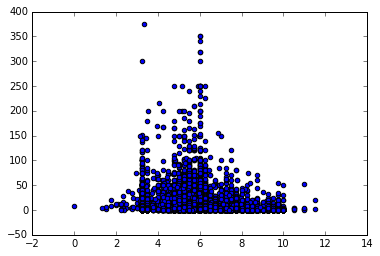

In [16]:
plt.scatter(x=df.InitialInterestRate, y=df.JobsSupported)

# Creating the metric

First, we need to group the SBA data set by unit of geography (we'll do city)

In [42]:
df = df.groupby(['BorrCity']).size().to_frame('number_of_loans')

In [45]:
df.reset_index(level=0, inplace=True)
df.BorrCity = df.BorrCity.str.lower()
city_profile.Name = city_profile.Name.str.lower()

In [49]:
combined = city_profile.merge(df, left_on=['Name'], right_on=['BorrCity'])
combined['service_metric'] = combined.number_of_loans / combined['# of businesses (census community survey)']
#businesses = businesses.reset_index()
#businesses.columns = businesses.columns.get_level_values(0)

In [51]:
combined = combined[['Name', 'City-Lat', 'City-Lon', 'service_metric']]

In [53]:
combined.head()

,Name,City-Lat,City-Lon,service_metric
0,blue lake,40.88291,-123.98395,0.560000
1,point arena,38.90880,-123.69307,0.081081
2,rio dell,40.49930,-124.10644,0.166667
3,trinidad,41.05929,-124.14312,0.183673
4,ross,37.96242,-122.55498,0.035088


In [54]:
combined.to_csv('./data/test_metric.csv')